In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import gensim
import random
from nltk.corpus import wordnet
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Embedding, Dense, ReLU, Dropout, Add, GlobalAveragePooling1D, Conv1D, LSTM, BatchNormalization, Permute, Flatten, Input, Bidirectional, MultiHeadAttention, LayerNormalization, MaxPooling1D, GRU, Activation

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df_train = pd.read_csv('PS_train.csv')
df_ev = pd.read_csv('PS_dev.csv')
df_test = pd.read_csv('PS_test.csv')

In [ ]:
print(df_train.shape)
print(df_ev.shape)
print(df_test.shape)

(4352, 2)
(544, 2)
(544, 3)


In [ ]:
df_train.head()

,content,labels
0,தென்காசி தொகுதி புதிய தமிழகம் கட்சி வேட்பாளர் ...,Neutral
1,அண்ணன் இதனை சூசகமாக 11 மாதங்கள் முன்பே பேட்டிய...,Substantiated
2,ஒரு வருடம் ஆகி விட்டது இந்த துயரம் நேர்ந்து......,Opinionated
3,"எடப்பாடியை கண்டுகொள்ளாத ""எடப்பாடி""🫢\n ---\nஆதர...",Positive
4,எங்களின் அரசியல் அடுத்த தலைமுறைக்குமானது \n#மக...,Opinionated


In [ ]:
df_ev.head()

,content,labels
0,ஒற்றே அறை...\n\nபாஜக குளோஸ்!\n\n#மக்களின்_சின்...,Opinionated
1,வாய்ப்பில்லை சார் வாய்ப்பில்லை\n#சீமானின்_சின்...,Substantiated
2,ஒரே போடு இரண்டாக பிளக்கும் | வரலாற்றில் ஒருவன்...,Neutral
3,இப்படியெல்லாம் எடிட் பண்ணிதான் ஓட்டு வாங்கணும்...,Negative
4,#Mike_VoiceOfPeople \n#NTK_Symbol_Mike \n#மக்க...,Substantiated


In [ ]:
df_test.head()

,Id,content
0,PS_01,இஸ்லாமிய சகோதரர்களுடன் ரமலான் கொண்டாடிய அதிமுக...
1,PS_02,\nஓபிஎஸ் - எடப்பாடி போட்டா போட்டி! திடீரென பணி...
2,PS_03,இன்றைய பரப்புரை:\n\nநாம் தமிழர் கட்சி தலைமை ஒர...
3,PS_04,"🇰🇬🎙️ இன்னும் 05 ஏ நாளில், வெல்வோம் தமிழராய் - ..."
4,PS_05,டாஸ்மாக்ல மட்டும்தான் கருணாநிதி அவர்களின் பெய...


In [ ]:
print(df_train['labels'].value_counts())

labels
Opinionated          1361
Sarcastic             790
Neutral               637
Positive              575
Substantiated         412
Negative              406
None of the above     171
Name: count, dtype: int64


In [ ]:
print(df_ev['labels'].value_counts())

labels
Opinionated          153
Sarcastic            115
Neutral               84
Positive              69
Substantiated         52
Negative              51
None of the above     20
Name: count, dtype: int64


In [ ]:
print(df_test['labels'].value_counts())

labels
Opinionated          171
Sarcastic            106
Positive              75
Neutral               70
Substantiated         51
Negative              46
None of the above     25
Name: count, dtype: int64


In [ ]:
def synonym_replacement(sentence, n=1):
    words = sentence.split()
    for _ in range(n):
        word_to_replace = random.choice(words)
        synonyms = wordnet.synsets(word_to_replace)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            words[words.index(word_to_replace)] = synonym
    return ' '.join(words)

df_train['augmented_content'] = df_train['content'].apply(lambda x: synonym_replacement(x, n=2))

df_combined = pd.concat([
    df_train[['content', 'labels']],
    df_train[['augmented_content', 'labels']].rename(columns={'augmented_content': 'content'})
], ignore_index=True)

print(df_combined.shape)
print(df_combined.head())

(8704, 2)
                                             content         labels
0  தென்காசி தொகுதி புதிய தமிழகம் கட்சி வேட்பாளர் ...        Neutral
1  அண்ணன் இதனை சூசகமாக 11 மாதங்கள் முன்பே பேட்டிய...  Substantiated
2  ஒரு வருடம் ஆகி விட்டது இந்த துயரம் நேர்ந்து......    Opinionated
3  எடப்பாடியை கண்டுகொள்ளாத "எடப்பாடி"🫢\n ---\nஆதர...       Positive
4  எங்களின் அரசியல் அடுத்த தலைமுறைக்குமானது \n#மக...    Opinionated


In [ ]:
#checking duplicate tweets in training data
duplicate_tweets_train = df_combined[df_combined.duplicated(subset=['content'])]
if not duplicate_tweets_train.empty:
  print("duplicate tweets found in combined data")
else:
  print("duplicate tweets not found in combined data")

duplicate tweets found in combined data


In [ ]:
#removing duplicate tweets from training data
cleaned_train = df_combined.drop_duplicates(subset=['content'], keep='first')
cleaned_train.shape

(7972, 2)

In [ ]:
#checking duplicate tweets in evaluation data
duplicate_tweets_ev = df_ev[df_ev.duplicated(subset=['content'])]
if not duplicate_tweets_ev.empty:
  print("duplicate tweets found in evaluation data")
else:
  print("duplicate tweets not found in evaluation data")

duplicate tweets found in evaluation data


In [ ]:
#removing duplicate tweets from evaluation data
cleaned_ev = df_ev.drop_duplicates(subset=['content'], keep='first')
cleaned_ev.shape

(540, 2)

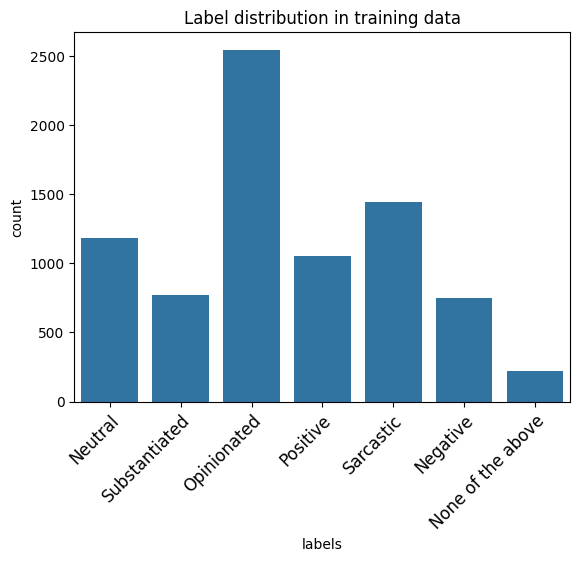

In [ ]:
sns.countplot(x = 'labels', data = cleaned_train)
plt.title('Label distribution in training data')
plt.xticks(ticks=range(len(cleaned_train['labels'].unique())), labels=cleaned_train['labels'].unique(), fontsize=12, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

In [ ]:
print(cleaned_train['labels'].value_counts())

labels
Opinionated          2542
Sarcastic            1445
Neutral              1182
Positive             1051
Substantiated         775
Negative              750
None of the above     223
Name: count, dtype: int64


In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(cleaned_train[['content']], cleaned_train['labels'])
cleaned_train = pd.DataFrame({'content': X_resampled['content'], 'labels': y_resampled})
print(cleaned_train['labels'].value_counts())

labels
Neutral              2544
Substantiated        2544
Opinionated          2544
Positive             2544
Sarcastic            2544
Negative             2544
None of the above    2544
Name: count, dtype: int64


In [ ]:
print(cleaned_train.shape)

(17794, 2)


In [ ]:
from bs4 import BeautifulSoup

In [ ]:
def text_preprocessing(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'@\w+', '', text)  # Remove @mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = BeautifulSoup(text, 'html.parser').get_text()
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)  # Remove emojis
    text = ' '.join(text.split())  # Clean extra spaces

    return text


In [ ]:
cleaned_train['cleaned_tweet'] = cleaned_train['content'].apply(text_preprocessing)
cleaned_ev['cleaned_tweet'] = cleaned_ev['content'].apply(text_preprocessing)
df_test['cleaned_tweet'] = df_test['content'].apply(text_preprocessing)

<ipython-input-11-caedc0d93696>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ev['cleaned_tweet'] = cleaned_ev['content'].apply(text_preprocessing)


In [ ]:
cleaned_train.head()

,content,labels,cleaned_tweet
0,தென்காசி தொகுதி புதிய தமிழகம் கட்சி வேட்பாளர் ...,Neutral,தனகச தகத பதய தமழகம கடச வடபளர டகடர கரஷணசமய ஆதரத...
1,அண்ணன் இதனை சூசகமாக 11 மாதங்கள் முன்பே பேட்டிய...,Substantiated,அணணன இதன சசகமக மதஙகள மனப படடயல சலலடடர
2,ஒரு வருடம் ஆகி விட்டது இந்த துயரம் நேர்ந்து......,Opinionated,ஒர வரடம ஆக வடடத இநத தயரம நரநத இனறவர ஒர ஆணய கட ...
3,"எடப்பாடியை கண்டுகொள்ளாத ""எடப்பாடி""🫢\n ---\nஆதர...",Positive,எடபபடய கணடகளளத எடபபட ஆதரபபர உதயசரயன மககளனகரல ஓ...
4,எங்களின் அரசியல் அடுத்த தலைமுறைக்குமானது \n#மக...,Opinionated,எஙகளன அரசயல அடதத தலமறககமனத மககளன_சனனம_மக


In [ ]:
cleaned_ev.head()

,content,labels,cleaned_tweet
0,ஒற்றே அறை...\n\nபாஜக குளோஸ்!\n\n#மக்களின்_சின்...,Opinionated,ஒறற அற பஜக களஸ மககளன_சனனம_மக சமனன_சனனம_மக மககள...
1,வாய்ப்பில்லை சார் வாய்ப்பில்லை\n#சீமானின்_சின்...,Substantiated,வயபபலல சர வயபபலல சமனன_சனனம_ஒலவஙக_மக ntk_symbol...
2,ஒரே போடு இரண்டாக பிளக்கும் | வரலாற்றில் ஒருவன்...,Neutral,ஒர பட இரணடக பளககம வரலறறல ஒரவன politicalrally s...
3,இப்படியெல்லாம் எடிட் பண்ணிதான் ஓட்டு வாங்கணும்...,Negative,இபபடயலலம எடட பணணதன ஓடட வஙகணமன இரகக உரபபடய வரசம...
4,#Mike_VoiceOfPeople \n#NTK_Symbol_Mike \n#மக்க...,Substantiated,mike_voiceofpeople ntk_symbol_mike மககளன_சனனம_...


In [ ]:
df_test.head()

,Id,content,cleaned_tweet
0,PS_01,இஸ்லாமிய சகோதரர்களுடன் ரமலான் கொண்டாடிய அதிமுக...,இஸலமய சகதரரகளடன ரமலன கணடடய அதமக வடபளர ரயபரம மன...
1,PS_02,\nஓபிஎஸ் - எடப்பாடி போட்டா போட்டி! திடீரென பணி...,ஓபஎஸ எடபபட படட படட தடரன பணகள மடககயளள எடபபட aia...
2,PS_03,இன்றைய பரப்புரை:\n\nநாம் தமிழர் கட்சி தலைமை ஒர...,இனறய பரபபர நம தமழர கடச தலம ஒரஙகணபபளர சமன அவரகள...
3,PS_04,"🇰🇬🎙️ இன்னும் 05 ஏ நாளில், வெல்வோம் தமிழராய் - ...",இனனம ஏ நளல வலவம தமழரய தல நமரவம நம தமழரய மக சனன...
4,PS_05,டாஸ்மாக்ல மட்டும்தான் கருணாநிதி அவர்களின் பெய...,டஸமகல மடடமதன கரணநத அவரகளன பயர பரததமனனத தமப சனன...


In [ ]:
# Vocabulary and OOV analysis
train_corpus = cleaned_train['cleaned_tweet'].sum()
ev_corpus = cleaned_ev['cleaned_tweet'].sum()
test_corpus = df_test['cleaned_tweet'].sum()

train_vocab = set(train_corpus.split())
dev_vocab = set(ev_corpus.split())
test_vocab = set(test_corpus.split())

oov_dev = dev_vocab - train_vocab
oov_test = test_vocab - train_vocab

print(f"Number of unique words in training data: {len(train_vocab)}")
print(f"Number of unique words in development data: {len(dev_vocab)}")
print(f"Number of unique words in test data: {len(test_vocab)}")
print(f"OOV words in dev dataset: {len(oov_dev)}")
print(f"OOV words in test dataset: {len(oov_test)}")

Number of unique words in training data: 25837
Number of unique words in development data: 3686
Number of unique words in test data: 4079
OOV words in dev dataset: 1343
OOV words in test dataset: 1614


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab = 10000

tokenizer = Tokenizer(num_words = vocab, oov_token = "<OOV>")
tokenizer.fit_on_texts(cleaned_train['cleaned_tweet'])

x_train_seq = tokenizer.texts_to_sequences(cleaned_train['cleaned_tweet'])
x_ev_seq = tokenizer.texts_to_sequences(cleaned_ev['cleaned_tweet'])
x_test_seq = tokenizer.texts_to_sequences(df_test['cleaned_tweet'])

max_train_seq = max([len(seq) for seq in x_train_seq])
min_train_seq = min([len(seq) for seq in x_train_seq])

max_ev_seq = max([len(seq) for seq in x_ev_seq])
min_ev_seq = min([len(seq) for seq in x_ev_seq])

max_test_seq = max([len(seq) for seq in x_test_seq])
min_test_seq = min([len(seq) for seq in x_test_seq])

print(f"max length of train seq: {max_train_seq}")
print(f"min length of train seq: {min_train_seq}")
print(f"max length of ev seq: {max_ev_seq}")
print(f"min length of ev seq: {min_ev_seq}")
print(f"max length of test seq: {max_test_seq}")
print(f"min length of test seq: {min_test_seq}")

max length of train seq: 324
min length of train seq: 1
max length of ev seq: 69
min length of ev seq: 1
max length of test seq: 347
min length of test seq: 2


In [ ]:
max_len = 300
x_train = pad_sequences(x_train_seq, maxlen = max_len, padding = 'post')
x_ev = pad_sequences(x_ev_seq, maxlen = max_len, padding = 'post')
x_test = pad_sequences(x_test_seq, maxlen = max_len, padding = 'post')

In [ ]:
print(cleaned_train['labels'].unique())
print(cleaned_ev['labels'].unique())
print(df_test['labels'].unique())

['Neutral' 'Substantiated' 'Opinionated' 'Positive' 'Sarcastic' 'Negative'
 'None of the above']
['Opinionated' 'Substantiated' 'Neutral' 'Negative' 'Sarcastic'
 'None of the above' 'Positive']
['Neutral' 'Negative' 'Substantiated' 'Positive' 'Opinionated' 'Sarcastic'
 'None of the above']


In [ ]:
le = LabelEncoder()

y_train = cleaned_train['labels']
y_ev = cleaned_ev['labels']
y_test = df_test['labels']

y_train = le.fit_transform(y_train)
y_ev = le.transform(y_ev)
y_test = le.transform(y_test)

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mapping:", label_mapping)

y_train = np.array(y_train)
y_ev = np.array(y_ev)
y_test = np.array(y_test)
print(y_train)

Label Mapping: {'Negative': 0, 'Neutral': 1, 'None of the above': 2, 'Opinionated': 3, 'Positive': 4, 'Sarcastic': 5, 'Substantiated': 6}
[1 6 3 ... 6 6 6]


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(17794, 300)
(17794,)
(544, 300)


In [ ]:
def build_lstm_model():
  inputs = Input(shape=(max_len,))
  x = Embedding(input_dim=vocab, output_dim=256)(inputs)

  x = LSTM(256, return_sequences=True)(x)
  x = LayerNormalization(epsilon=1e-5)(x)
  x = LSTM(256)(x)
  x = LayerNormalization(epsilon=1e-5)(x)

  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)

  outputs = Dense(7, activation='softmax')(x)

  model = Model(inputs, outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  return model

def build_gru_model():
  inputs = Input(shape=(max_len,))
  x = Embedding(input_dim=vocab, output_dim=256)(inputs)

  x = GRU(256, return_sequences=True)(x)
  x = LayerNormalization(epsilon=1e-5)(x)
  x = GRU(256)(x)
  x = LayerNormalization(epsilon=1e-5)(x)

  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)

  outputs = Dense(7, activation='softmax')(x)

  model = Model(inputs, outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  return model

def build_bilstm_model():
  inputs = Input(shape=(max_len,))
  x = Embedding(input_dim=vocab, output_dim=256)(inputs)

  x = Bidirectional(LSTM(256, return_sequences=True))(x)
  x = LayerNormalization(epsilon=1e-5)(x)
  x = Bidirectional(LSTM(256))(x)
  x = LayerNormalization(epsilon=1e-5)(x)

  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)

  outputs = Dense(7, activation='softmax')(x)

  model = Model(inputs, outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  return model

def build_CNN_BiLSTM_model():
  inputs = Input(shape=(max_len,))
  x = Embedding(vocab, 256)(inputs)

  x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2, strides=1)(x)

  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = LayerNormalization(epsilon=1e-5)(x)
  x = Bidirectional(LSTM(128))(x)
  x = LayerNormalization(epsilon=1e-5)(x)

  x = Dense(128, activation='relu')(x)
  x = Dense(64, activation='relu')(x)

  outputs = Dense(7, activation='softmax')(x)

  model = Model(inputs, outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  return model

def build_CNN_BiGRU_model():
  inputs = Input(shape=(max_len,))
  x = Embedding(vocab, 256)(inputs)

  x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2, strides=1)(x)

  x = Bidirectional(GRU(128, return_sequences=True))(x)
  x = LayerNormalization(epsilon=1e-5)(x)
  x = Bidirectional(GRU(128))(x)
  x = LayerNormalization(epsilon=1e-5)(x)

  x = Dense(128, activation='relu')(x)
  x = Dense(64, activation='relu')(x)

  outputs = Dense(7, activation='softmax')(x)

  model = Model(inputs, outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  return model

def build_biGRU_model():
  inputs = Input(shape=(max_len,))
  x = Embedding(vocab, 256)(inputs)

  x = Bidirectional(GRU(256, return_sequences=True))(x)
  x = LayerNormalization(epsilon=1e-5)(x)
  x = Bidirectional(GRU(256))(x)
  x = LayerNormalization(epsilon=1e-5)(x)

  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)

  outputs = Dense(7, activation='softmax')(x)

  model = Model(inputs, outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  return model

##GRU model

In [ ]:
gru_model = build_gru_model()
gru_model.fit(x_train, y_train, validation_data=(x_ev, y_ev), epochs=8, batch_size=64,
                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                                            patience=3, verbose=1, mode='auto',
                                                            restore_best_weights=True)])

Epoch 1/8
279/279 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 1.8731 - sparse_categorical_accuracy: 0.2105 - val_loss: 2.4175 - val_sparse_categorical_accuracy: 0.2741
Epoch 2/8
279/279 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.7383 - sparse_categorical_accuracy: 0.7431 - val_loss: 2.7494 - val_sparse_categorical_accuracy: 0.3019
Epoch 3/8
279/279 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 0.3442 - sparse_categorical_accuracy: 0.8929 - val_loss: 2.8843 - val_sparse_categorical_accuracy: 0.2963
Epoch 4/8
279/279 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 0.1974 - sparse_categorical_accuracy: 0.9373 - val_loss: 2.9213 - val_sparse_categorical_accuracy: 0.2778
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
y_test_gru = gru_model.predict(x_test, batch_size = 64)
y_test_gru = np.argmax(y_test_gru, axis = -1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [ ]:
print("Classification report on test set\n", classification_report(y_test, y_test_gru))

Classification report on test set
               precision    recall  f1-score   support

           0       0.15      0.09      0.11        46
           1       0.07      0.03      0.04        70
           2       1.00      0.36      0.53        25
           3       0.33      0.79      0.47       171
           4       0.42      0.13      0.20        75
           5       0.19      0.05      0.08       106
           6       0.16      0.08      0.11        51

    accuracy                           0.31       544
   macro avg       0.33      0.22      0.22       544
weighted avg       0.28      0.31      0.24       544



### Train BiLSTM

In [ ]:
bilstm_model = build_bilstm_model()
bilstm_model.fit(x_train, y_train, validation_data=(x_ev, y_ev), epochs=8, batch_size=64,
                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                                            patience=3, verbose=1, mode='auto',
                                                            restore_best_weights=True)])

Epoch 1/8
279/279 ━━━━━━━━━━━━━━━━━━━━ 47s 147ms/step - loss: 1.3107 - sparse_categorical_accuracy: 0.5331 - val_loss: 2.6536 - val_sparse_categorical_accuracy: 0.2963
Epoch 2/8
279/279 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - loss: 0.2940 - sparse_categorical_accuracy: 0.9068 - val_loss: 3.0396 - val_sparse_categorical_accuracy: 0.2981
Epoch 3/8
279/279 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - loss: 0.1696 - sparse_categorical_accuracy: 0.9446 - val_loss: 3.3454 - val_sparse_categorical_accuracy: 0.3148
Epoch 4/8
279/279 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.9620 - val_loss: 4.5624 - val_sparse_categorical_accuracy: 0.3000
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
y_test_bilstm = bilstm_model.predict(x_test, batch_size = 64)
y_test_bilstm = np.argmax(y_test_bilstm, axis = -1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


In [ ]:
print("Classification report on test set\n", classification_report(y_test, y_test_bilstm))

Classification report on test set
               precision    recall  f1-score   support

           0       0.21      0.07      0.10        46
           1       0.15      0.09      0.11        70
           2       0.92      0.44      0.59        25
           3       0.36      0.86      0.50       171
           4       0.39      0.15      0.21        75
           5       0.43      0.11      0.18       106
           6       0.09      0.02      0.03        51

    accuracy                           0.35       544
   macro avg       0.36      0.25      0.25       544
weighted avg       0.34      0.35      0.28       544



###CNN-BiLSTM

In [ ]:
cnn_Bilstm_model = build_CNN_BiLSTM_model()
cnn_Bilstm_model.fit(x_train, y_train, validation_data=(x_ev, y_ev), epochs=8, batch_size=32,
                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                                            patience=3, verbose=1, mode='auto',
                                                            restore_best_weights=True)])

Epoch 1/8
557/557 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - loss: 1.4265 - sparse_categorical_accuracy: 0.4295 - val_loss: 2.3238 - val_sparse_categorical_accuracy: 0.3167
Epoch 2/8
557/557 ━━━━━━━━━━━━━━━━━━━━ 72s 59ms/step - loss: 0.3998 - sparse_categorical_accuracy: 0.8715 - val_loss: 2.6579 - val_sparse_categorical_accuracy: 0.3222
Epoch 3/8
557/557 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - loss: 0.1968 - sparse_categorical_accuracy: 0.9402 - val_loss: 3.5935 - val_sparse_categorical_accuracy: 0.3074
Epoch 4/8
557/557 ━━━━━━━━━━━━━━━━━━━━ 53s 82ms/step - loss: 0.1394 - sparse_categorical_accuracy: 0.9559 - val_loss: 3.9601 - val_sparse_categorical_accuracy: 0.3019
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
y_pred_cnn_bilstm = cnn_Bilstm_model.predict(x_test, batch_size = 32)
y_pred_cnn_bilstm = np.argmax(y_pred_cnn_bilstm, axis = -1)
print(classification_report(y_test, y_pred_cnn_bilstm))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
              precision    recall  f1-score   support

           0       0.22      0.04      0.07        46
           1       0.16      0.11      0.13        70
           2       0.91      0.40      0.56        25
           3       0.36      0.82      0.50       171
           4       0.45      0.12      0.19        75
           5       0.39      0.20      0.26       106
           6       0.20      0.02      0.04        51

    accuracy                           0.35       544
   macro avg       0.38      0.25      0.25       544
weighted avg       0.35      0.35      0.29       544



##CNN-BiGRU

In [ ]:
cnn_BiGRU_model = build_CNN_BiGRU_model()
cnn_BiGRU_model.fit(x_train, y_train, validation_data=(x_ev, y_ev), epochs=8, batch_size=32,
                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                                            patience=3, verbose=1, mode='auto',
                                                            restore_best_weights=True)])

Epoch 1/8
557/557 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - loss: 1.2748 - sparse_categorical_accuracy: 0.5150 - val_loss: 3.1421 - val_sparse_categorical_accuracy: 0.2833
Epoch 2/8
557/557 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - loss: 0.2487 - sparse_categorical_accuracy: 0.9244 - val_loss: 3.4614 - val_sparse_categorical_accuracy: 0.3093
Epoch 3/8
557/557 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - loss: 0.1013 - sparse_categorical_accuracy: 0.9692 - val_loss: 4.1906 - val_sparse_categorical_accuracy: 0.2685
Epoch 4/8
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - loss: 0.0674 - sparse_categorical_accuracy: 0.9782 - val_loss: 4.8095 - val_sparse_categorical_accuracy: 0.3056
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
y_pred_cnn_bigru = cnn_BiGRU_model.predict(x_test, batch_size = 32)
y_pred_cnn_bigru = np.argmax(y_pred_cnn_bigru, axis = -1)
print(classification_report(y_test, y_pred_cnn_bigru))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
              precision    recall  f1-score   support

           0       0.12      0.04      0.06        46
           1       0.23      0.04      0.07        70
           2       0.82      0.36      0.50        25
           3       0.36      0.81      0.50       171
           4       0.40      0.16      0.23        75
           5       0.50      0.16      0.24       106
           6       0.12      0.12      0.12        51

    accuracy                           0.35       544
   macro avg       0.36      0.24      0.25       544
weighted avg       0.35      0.35      0.28       544



##BiGRU

In [ ]:
biGRU_model = build_biGRU_model()
biGRU_model.fit(x_train, y_train, validation_data=(x_ev, y_ev), epochs=4, batch_size=64,
                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                                            patience=3, verbose=1, mode='auto',
                                                            restore_best_weights=True)])

Epoch 1/4
279/279 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - loss: 1.2648 - sparse_categorical_accuracy: 0.5479 - val_loss: 2.9095 - val_sparse_categorical_accuracy: 0.2944
Epoch 2/4
279/279 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - loss: 0.2426 - sparse_categorical_accuracy: 0.9233 - val_loss: 3.3534 - val_sparse_categorical_accuracy: 0.2889
Epoch 3/4
279/279 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.9622 - val_loss: 4.2806 - val_sparse_categorical_accuracy: 0.2870
Epoch 4/4
279/279 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - loss: 0.0667 - sparse_categorical_accuracy: 0.9760 - val_loss: 4.6781 - val_sparse_categorical_accuracy: 0.3037
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
y_pred_biGRU = biGRU_model.predict(x_test, batch_size = 64)
y_pred_biGRU = np.argmax(y_pred_biGRU, axis = -1)
print(classification_report(y_test, y_pred_biGRU))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
              precision    recall  f1-score   support

           0       0.15      0.04      0.07        46
           1       0.24      0.06      0.09        70
           2       0.92      0.44      0.59        25
           3       0.37      0.87      0.52       171
           4       0.40      0.13      0.20        75
           5       0.41      0.23      0.29       106
           6       0.27      0.08      0.12        51

    accuracy                           0.37       544
   macro avg       0.39      0.26      0.27       544
weighted avg       0.36      0.37      0.30       544



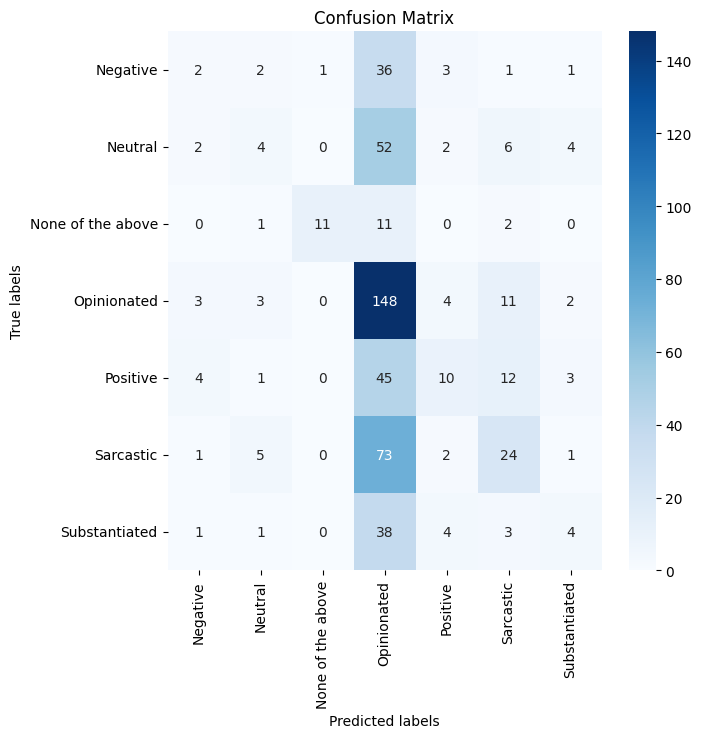

In [ ]:
classes = ['Negative', 'Neutral', 'None of the above', 'Opinionated', 'Positive', 'Sarcastic', 'Substantiated']

cnf_matrix = confusion_matrix(y_test, y_pred_biGRU)

plt.figure(figsize=(7, 7))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
y_test_pred = biGRU_model.predict(x_test, batch_size = 64)
y_test_biGRU = np.argmax(y_test_pred, axis = -1)

label_mapping = {'Negative': 0, 'Neutral': 1, 'None of the above': 2, 'Opinionated': 3,
                 'Positive': 4, 'Sarcastic': 5, 'Substantiated': 6}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Step 2: Convert numeric predictions to original labels
original_labels = [reverse_label_mapping[label] for label in y_test_biGRU]

prediction_df2 = pd.DataFrame({
    'Id': df_test['Id'],
    'Labels': original_labels
})
output_file = 'predictionBiGRU.csv'
prediction_df2.to_csv(output_file, index=False)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
